In [1]:
import torch
import cv2
from apis.inference import inf_single_pose, process_yolo, vis_pose_result

from mmcv import Config
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, collate
from mmcv.runner import load_checkpoint
from mmpose.models import build_posenet

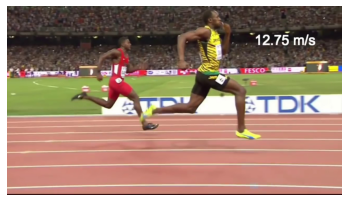

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img = np.array(Image.open('images/run.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()


In [3]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

#yolo_model.to(torch.device('cpu'));

Using cache found in /home/nami-labs/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv         

In [4]:
#yolo_model.to(torch.device('cuda:0'))
print(next(yolo_model.parameters()).is_cuda)

print(next(yolo_model.parameters()).get_device())

True
torch.float16
0


In [28]:
det_results = yolo_model(img_)

det_results_xyxy, det_results_xywh = process_yolo(det_results, score_thr=0.3)

In [6]:
cfg_file = 'configs/pose/top_down/mobilenet_v2/coco/mobilenetv2_coco_256x192.py'
ckpt_file = 'https://download.openmmlab.com/mmpose/top_down/mobilenetv2/mobilenetv2_coco_256x192-d1e58e7b_20200727.pth'

In [7]:
cfg = Config.fromfile(cfg_file)
pose_model = build_posenet(cfg.model)
    
load_checkpoint(pose_model, ckpt_file, map_location='cpu')

pose_model = fuse_conv_bn(pose_model)
#pose_model = pose_model.to(torch.device('cpu'))
model_parallel = MMDataParallel(pose_model, device_ids=[0])

Use load_from_mmcls loader
Use load_from_http loader


In [8]:
import time 

s = time.time()
pose_results = inf_single_pose(pose_model, cfg, img, det_results_xywh, det_results_xyxy)
print(1/(time.time()-s))

18.824408021111967


<ipython-input-19-acd784300196>:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


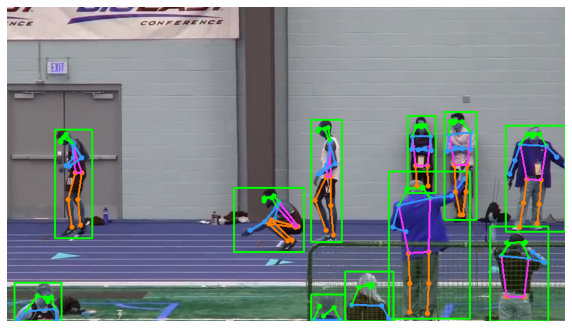

In [19]:
vis_result = vis_pose_result(pose_model, img, pose_results, radius=4, thickness=2)

plt.figure(figsize=(10, 10))
plt.imshow(vis_result)
plt.axis('off')
plt.show()

In [10]:
import time
from IPython.display import clear_output

torch.backends.cudnn.benchmark = True

video_path = 'videos/500m-running.mp4'
out_video_path = 'visual_result/tiki-taka.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

print(fps, size)

29.97002997002997 (854, 480)


In [11]:
FONT_SCALE = 0.5
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_COLOR = (39, 0, 247)
FONT_THICKNESS = 2

In [12]:
video_path = 'videos/500m-running.mp4'
cap = cv2.VideoCapture(video_path)
dataset = cfg.data['test']['type']
count = 0

while (cap.isOpened()):
    flag, img = cap.read()
    if not flag:
        break
    s1 = time.time()

    # test a single image, the resulting box is (x1, y1, x2, y2)
    det_results = yolo_model(img)
    time_det = time.time()-s1

    # keep the person class bounding boxes.
    det_results_xyxy, det_results_xywh = process_yolo(det_results, score_thr=0.3)
    
    s2 = time.time()
    if len(det_results_xyxy) == 0:
        vis_img = img
        time_pose = time.time() - s2
    else:
        # test aq single image, with a list of bboxes.
        pose_results = inf_single_pose(pose_model, cfg, img, det_results_xywh, det_results_xyxy)
        time_pose = time.time() - s2

        # show the results
        vis_img = vis_pose_result(
            pose_model,
            img,
            pose_results,
            dataset=dataset,
            kpt_score_thr=0.3,
            thickness=2, radius = 5,
            show=False )

    fps_process = 1 / (time.time()-s1)
    
    cv2.putText(vis_img,f'FPS {fps_process:.2f}', (15, 30),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.putText(vis_img,f'Detection {1/time_det:.2f}', (15, 55),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    cv2.putText(vis_img,f'Pose {1/time_pose:.2f}', (15, 80),  FONT_FACE, FONT_SCALE, FONT_COLOR, FONT_THICKNESS)
    
    cv2.imshow('Image', vis_img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    # Frame Skipping
    #count += 10
    #   cap.set(1, count)

cap.release()
    
cv2.destroyAllWindows()